# **California Housing Prices: End-to-End Machine Learning Project**
**from Chapter 2 of O'Reilly Hands on ML w/ Scikit-Learn, Keras, and Tensorflow**
**recreated by Luis Hasbun**

# **Part 1: Get the Data**

In [1]:
import os
import tarfile
import urllib

In [2]:
# Fetch the data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datsets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True) # Make datasets/housing directory
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) # Download "housing.tgz" file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path) # Extract "housing.csv" file
    housing_tgz.close

In [3]:
#Load the data using pandas
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info() # Quick description of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts() # Check count for each category for ocean_proximity object type attribute

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe() # Summary of numerical attributes

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


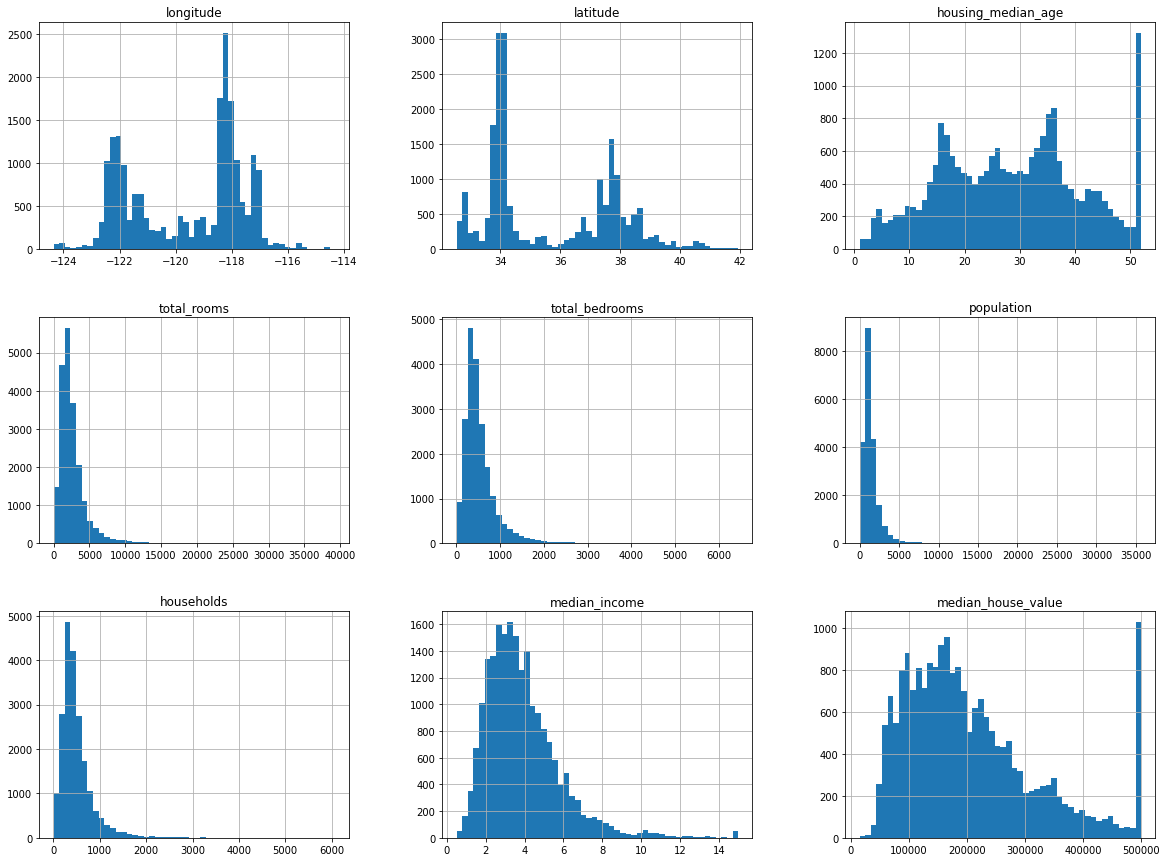

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15)) # Create histogram for each numerical attribute
plt.show()

# **Part 2: Create a Test Set**

In [9]:
# Split into training and testing sets (simple method)
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # Shuffle data randomly
    test_set_size = int(len(data) * test_ratio) # Set size of test set
    test_indices = shuffled_indices[:test_set_size] # Assign test indices from beginning up to test set size
    train_indices = shuffled_indices[test_set_size:] # Assign train indices from test set size to end
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2) # Split data into training set and testing set on an 80/20 split

In [10]:
len(train_set)

16512

In [11]:
len(test_set)

4128

In [12]:
# Split into training and testing sets (using stabalizer so algorithm does not see full dataset after multiple runs)
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32 # Hash each instance's identifier and check so test set remains cosistent across multiple runs and in case of updated data

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # Adds and "index" column
train_set_id, test_set_id = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
len(train_set_id)

16512

In [14]:
len(test_set_id)

4128

In [15]:
# Last method only works if data appended at end of dataset and no row ever gets deleted
# Use most stable feature (lat/long) to create a unique identifier
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set_id2, test_set_id2 = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
len(train_set_id2)

16512

In [17]:
len(test_set_id2)

4128

In [18]:
# Split into training and testing sets (using Scikit-Learn function)
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [19]:
len(train_set)

16512

In [20]:
len(test_set)

4128

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.,1.5,3.0,4.5,6., np.inf],
                               labels=[1,2,3,4,5])

<AxesSubplot:>

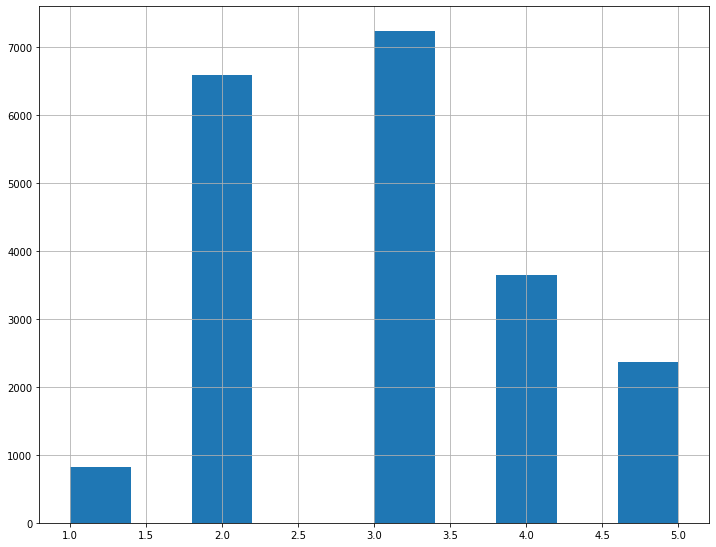

In [22]:
housing["income_cat"].hist(figsize=(12,9.5))

In [23]:
# Startified sampling based on income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [24]:
# Check income category proportions in stratified test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [25]:
# Remove income_cat attribute to revert data to original shape
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# **Part 3: Discover and Visualize the Data to Gain Insights**

**Part 3A: Visualizing Geographical Data**

In [26]:
# Create copy of training set to manipulate for visualizations
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

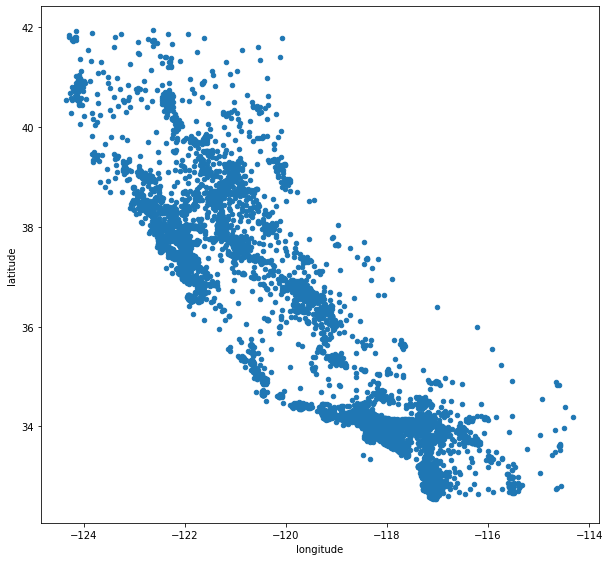

In [27]:
# Create geographical scatterplot of data
housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,9.5))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

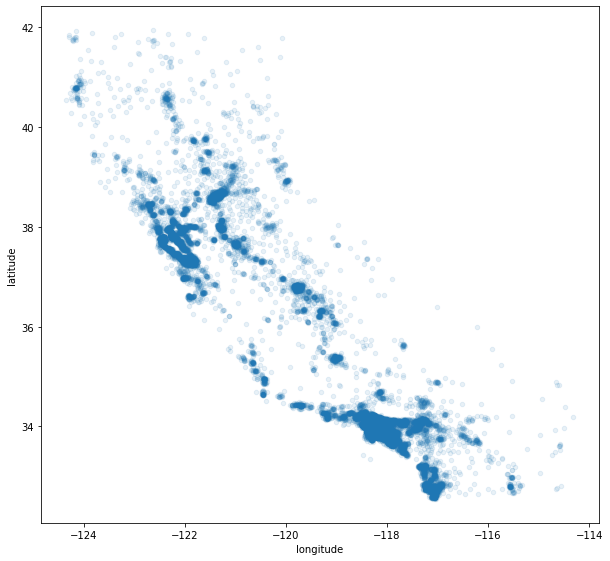

In [28]:
# Set alpha option on scatterplot to better visualize high-density areas
housing.plot(alpha=0.1, kind="scatter", x="longitude", y="latitude", figsize=(10,9.5))

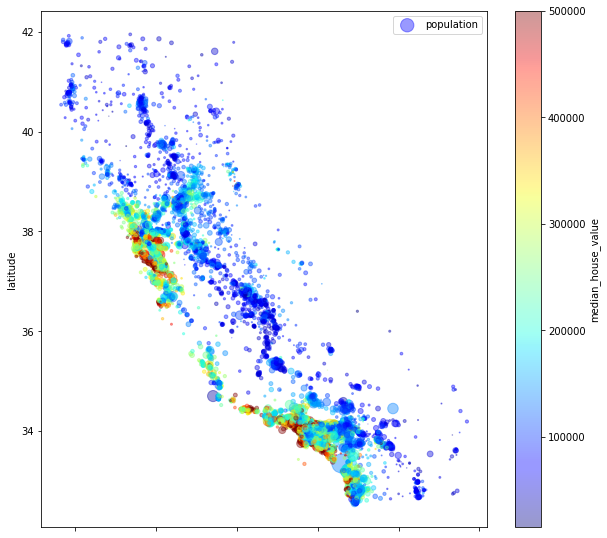

In [29]:
# Create scatterplot of housing prices, colors and radius determine price and population respectively
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", figsize=(10,9.5), 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

**Part 3B: Looking for Correlations**

In [30]:
corr_matrix = housing.corr() # Compute standard correlation coefficient (Pearson's r)

In [31]:
corr_matrix["median_house_value"].sort_values(ascending=False) # Look at how much each attribute correlates with median house value (range from -1 [strong negative correlation] to 1 [strong positive correlation])
# Close to 0 means no there is no linear correlation

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

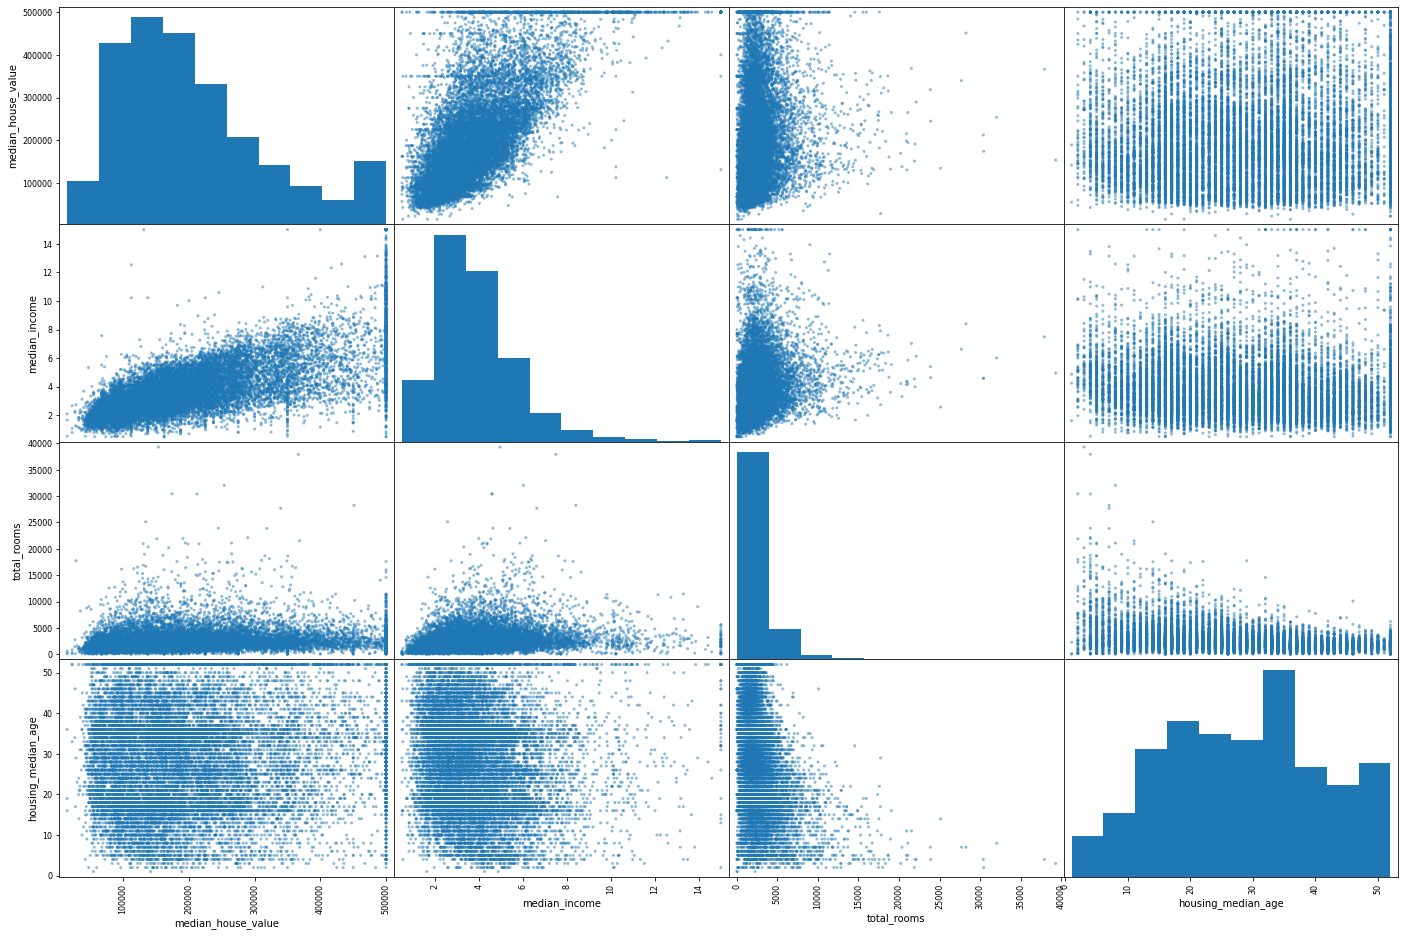

In [32]:
# Use scatter matrix to plot numerical attributes against other numerical attributes
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(24,16))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

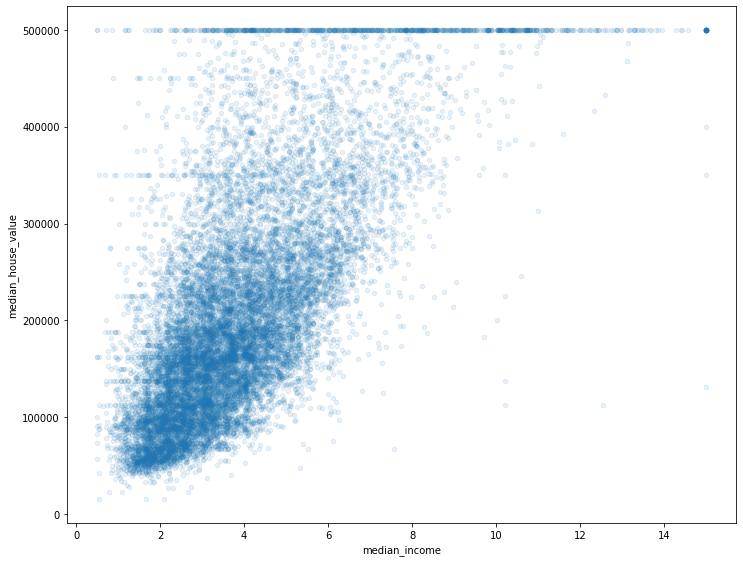

In [33]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(12,9.5))

**Part 3C: Experimenting with Attribute Combinations**

In [34]:
# Create new attributes 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] # Rooms per hosuehold attribute
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] # Bedrooms per room attribute
housing["population_per_household"] = housing["population"]/housing["households"] # Population per household attribute

In [35]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False) # Look at correlation matrix with new attributes included

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# **Part 4: Prepare the Data for Machine Learning Algorithms**

In [36]:
# Create copy of training set and separate predictors and labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

**Part 4A: Data Cleaning**

In [37]:
# Take care of missing values in total_bedrooms
# Option 1: Drop N/A values -> housing.dropna(subset=["total_bedrooms"])
# Option 2: Get rid of whole attribute -> housing.drop("total_bedrooms", axis=1)
# Option 3: Set N/A values to zero, mean, median, etc. -> median = housing["total_bedrooms"].median -> housing["total_bedrooms"].fillna(median, inplace=True)
# Option 4: Take care of missing values using Scikit-Learn's SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1) # Drop non-numerical attribute in copy

imputer.fit(housing_num) # Fit imputer instance to numerical-only copy of training data

SimpleImputer(strategy='median')

In [38]:
imputer.statistics_ # Imputer computes median for each numerical attribute and stres in statistics_ instance variable

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [39]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [40]:
X = imputer.transform(housing_num) # Transform training set by replacing N/A values with median values

In [41]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # Put results back into pandas data frame

**Part 4B: Handling Text and Categorical Attributes**

In [42]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN


In [43]:
housing_cat.value_counts() # Five different values for ocean_proximity categorical attribute

ocean_proximity
<1H OCEAN          7277
INLAND             5262
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [44]:
# Convert categorical attributes from texts to numbers using Scikit-Learn's OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [45]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
# Convert categorical attributes from text to numbers using one-hot encoding using Scikit-Learn's OneHotEncoder
# Ordinal encoder has issue that neare values will be assumed to be more similar even if they are not(e.g. <1H OCEAN not similar to INLAND in previous example)
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Part 4C: Custom Transformers**

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# Add new attributes using a single class
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # No *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # Nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [49]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

**Part 4D: Feature Scaling and Transformation Pipelines**

In [50]:
# Small pipeline for numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # Scaler for standardization (could aso use MinMaxScaler())

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # Fill in NA numerical values with median values
        ('attribs_adder', CombinedAttributesAdder()), # Add extra attributes (e.g. bedrooms per rooms)
        ('std_scaler', StandardScaler()) # Standardization feature scaling
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [51]:
housing_num_tr[1]

array([ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
        0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
       -0.81086696])

In [52]:
# Full pipeline wchih also includes numerical and categorical columns
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), # Numerical pipeline
        ("cat", OneHotEncoder(), cat_attribs) # One-hot encoder transformation of categorical attributes
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [53]:
housing_prepared[1]

array([ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
        0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
       -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ])

# **Part 5: Select and Train a Model**

**Part 5A: Linear Regression Model**

In [54]:
import joblib

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) # Train model

LinearRegression()

In [56]:
# Test linear regression model on some instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [57]:
# Measure RMSE on whole training set when using LinearRegression model
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [58]:
# Save linear regression model
joblib.dump(lin_reg, "line_reg.pkl")

['line_reg.pkl']

**Part 5B: DecisionTreeRegressor Model**

In [59]:
# LinearRegression result in underfitting (RMSE=$68,627.87) 
# Use more complex model to reduce underfitting, DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels) #Train model

DecisionTreeRegressor()

In [60]:
# Evaluate DecisionTreeRegressor on training set
# Result of RMSE=$0 mean this model overfits the data
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [61]:
# Save decision tree regression model
joblib.dump(tree_reg, "tree_reg.pkl")

['tree_reg.pkl']

**Part 5C: Better Evaluation Using Cross-Validation**

In [62]:
# Use K-fold cross-validation to possibly improve evaluation
from sklearn.model_selection import cross_val_score

# Split training set into 10 folds for cross-validation using DecitionTreeRegressorModel
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [63]:
# Display results of cross-validation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [71804.29878841 70844.65357125 68901.50424793 71701.70845467
 70649.11474299 76704.80325857 71788.36521035 73829.7173038
 69520.7956411  71830.02317355]
Mean: 71757.49843926149
Standard Deviation: 2097.6838128486343


In [64]:
# Compute cross-validation scores for LinearReression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
# Linear regression has better perfromance than decision tree in CV (less overfitting)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard Deviation: 2880.3282098180694


In [65]:
# Use RandomForestRegressor model for possible better evaluation
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18697.029419530598

In [66]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51380.10036071 49070.70844362 46764.07651636 51714.43262682
 47506.70918325 51507.87256    52436.96443281 50029.39323821
 48489.12443868 53894.85592542]
Mean: 50279.4237725875
Standard Deviation: 2174.406801504632


# **Part 6: Fine-Tune Your Model**

**Part 6A: Grid Search**

In [67]:
# Use Scikit_Learn GridSearchCV to experiment with hyperparameter and find best combination
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # First dict: 3x4=12 combinations of hyperparams
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] # Second dict: 2x3=6 combinations of hyperparams plus boostrap hyper param equals False

forest_reg = RandomForestRegressor()

# 18 combinations trained 5 times (cv=5) for a ttal of 90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True) 

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
# Show best combination of hyperparameters
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [69]:
# Get best estimator
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [70]:
# Evaluation scores for grid search shows best solution (max_features=8, n_estimators=30)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63555.16057117268 {'max_features': 2, 'n_estimators': 3}
55307.18440161928 {'max_features': 2, 'n_estimators': 10}
52779.778471485995 {'max_features': 2, 'n_estimators': 30}
59849.3467345376 {'max_features': 4, 'n_estimators': 3}
52906.46898777723 {'max_features': 4, 'n_estimators': 10}
50566.608297742314 {'max_features': 4, 'n_estimators': 30}
58598.30500072437 {'max_features': 6, 'n_estimators': 3}
52213.525355995 {'max_features': 6, 'n_estimators': 10}
49987.073190931915 {'max_features': 6, 'n_estimators': 30}
58712.95036438461 {'max_features': 8, 'n_estimators': 3}
51967.54642613159 {'max_features': 8, 'n_estimators': 10}
49929.45469853743 {'max_features': 8, 'n_estimators': 30}
61810.52455790383 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54521.71280314466 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59660.5619212327 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52577.440954535276 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

**Part 6B: Ensemble Methods**

In [71]:
# Indicate the relative importance of each attribute for making accurate predictions when using RandomForestRegresor
feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances

array([7.06842342e-02, 6.18912087e-02, 4.47651690e-02, 1.62398175e-02,
       1.48984567e-02, 1.45779836e-02, 1.45348405e-02, 3.92197429e-01,
       4.29539336e-02, 1.10069105e-01, 6.01864717e-02, 6.17972693e-03,
       1.44348182e-01, 5.16788301e-05, 2.85662881e-03, 3.56513425e-03])

In [72]:
# Display importance scores next to corresponding attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3921974292727382, 'median_income'),
 (0.14434818175295305, 'INLAND'),
 (0.11006910452980964, 'pop_per_hhold'),
 (0.07068423424052853, 'longitude'),
 (0.06189120871112448, 'latitude'),
 (0.060186471726361865, 'bedrooms_per_room'),
 (0.044765168956619326, 'housing_median_age'),
 (0.042953933583427924, 'rooms_per_hhold'),
 (0.01623981754114411, 'total_rooms'),
 (0.01489845671794381, 'total_bedrooms'),
 (0.014577983633866854, 'population'),
 (0.014534840510933346, 'households'),
 (0.006179726934080554, '<1H OCEAN'),
 (0.0035651342492002114, 'NEAR OCEAN'),
 (0.0028566288091700326, 'NEAR BAY'),
 (5.167883009810356e-05, 'ISLAND')]

**Part 6C: Evaluate System on the Test Set**

In [73]:
# Assign best scoring estimator as final model
final_model = grid_search.best_estimator_

# Create test set (X=attributes, y=labels)
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Run full pipeline to transform the data
X_test_prepared = full_pipeline.transform(X_test)

# Make predictions using final model
final_predictions = final_model.predict(X_test_prepared)

# Calculate RMSE
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47768.904400378466

In [74]:
# Compute 95% confidence interval for generalization error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45786.81706285, 49671.96229744])